In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns # get more colormaps
plt.style.use("bioAI.mplstyle")
import torch
import scipy
import umap as umap
from ripser import ripser
from persim import plot_diagrams
import tqdm

import sys
sys.path.append('../')
from methods import *
from models import JacobianCI, JitterCI
from plotting_functions import set_size, project_cmap, minimal_ticks, scatter3d

import umap.umap_ as umap


In [122]:
N = np.arange(0,100,5)
A = np.linspace(0.1,2,20)

N_grid, A_grid = np.meshgrid(N,A)

sigma = 3*(np.pi**2)*(A_grid**2)*N_grid

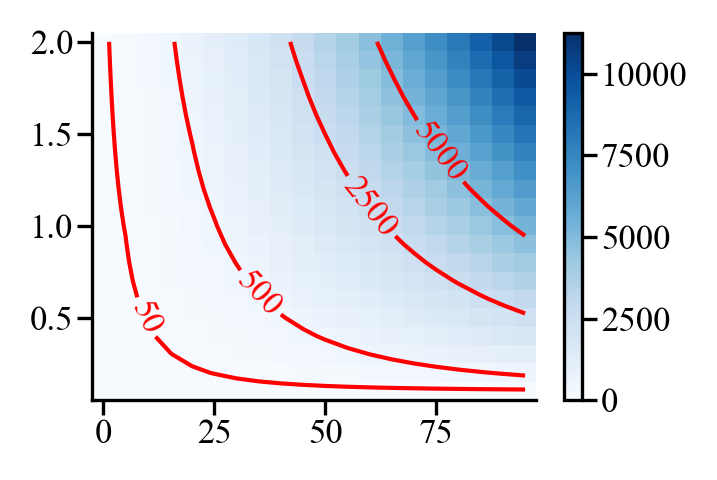

In [151]:
figsize=set_size(fraction=(1/2,1/3),mode='square')
fig, ax = plt.subplots(1,1,figsize=figsize,dpi=300)
c = ax.pcolormesh(N_grid, A_grid, sigma.T)
plt.colorbar(c)
cs = ax.contour(N_grid,A_grid,sigma.T,levels=[50,500,2500,5000],colors='red')
ax.clabel(cs, inline=True, fontsize=8)
#ax.set_xlabel('N')
#ax.set_ylabel('A',rotation=0)
fig.savefig('./F4-P1_scale.png',dpi=300)

In [125]:
energy = np.zeros([len(A),len(N)])
res = 100

for c1, a in enumerate(A):
    for c2, n in enumerate(N):
        model = JacobianCI(ncells=n,lr=1e-3, shift=0, p_magnitude=0)
        rs = model.unit_cell.mesh(res)
        nsamples_space = 2**8
        for epoch in tqdm.trange(4000):
            r_samples = model.unit_cell.sample(nsamples_space)
            r_samples = torch.tensor(r_samples,dtype=torch.float32)
            loss_CI = model.train_step(r_samples)
        activity = a*model.forward(torch.Tensor(rs)).detach().numpy()
        energy[c1,c2] = np.linalg.norm(activity)
        


100%|██████████████████████████████████████| 4000/4000 [00:10<00:00, 387.43it/s]


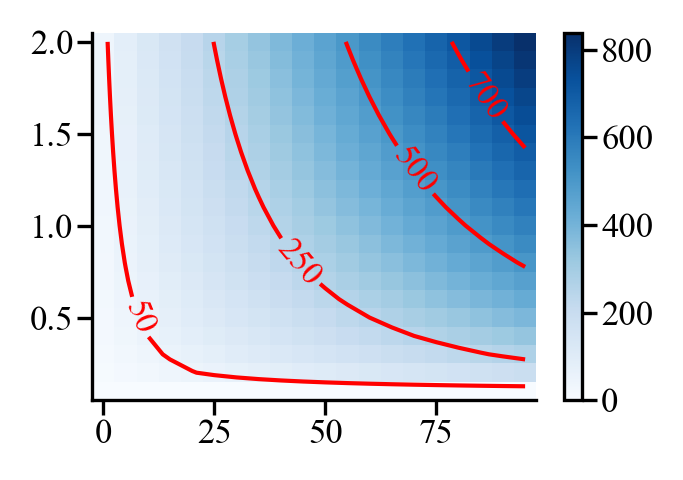

In [152]:
figsize=set_size(fraction=(1/2,1/3),mode='square')
fig, ax = plt.subplots(1,1,figsize=figsize,dpi=300)
c = ax.pcolormesh(N_grid, A_grid, energy.T)
plt.colorbar(c)
cs = ax.contour(N_grid,A_grid,energy.T,levels=[50,250,500,700],colors='red')
ax.clabel(cs, inline=True, fontsize=8)
#ax.set_xlabel('N')
#ax.set_ylabel('A',rotation=0)
fig.savefig('./F4-P1_energy.pdf')

In [178]:
#Torus scale 

model_small = JacobianCI(ncells=10,lr=1e-3, shift=0, p_magnitude=0)
model_big = JacobianCI(ncells=100,lr=1e-3, shift=0, p_magnitude=0)

rs = model.unit_cell.mesh(res)
nsamples_space = 2**8
for epoch in tqdm.trange(4000):
    r_samples = model_small.unit_cell.sample(nsamples_space)
    r_samples = torch.tensor(r_samples,dtype=torch.float32)
    loss_CI_small = model_small.train_step(r_samples)
    loss_CI_big = model_big.train_step(r_samples)



100%|██████████████████████████████████████| 4000/4000 [00:13<00:00, 287.72it/s]


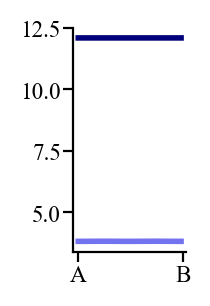

In [217]:
#parametrized curve
curve = np.array([(np.sqrt(3)/2)*np.linspace(-0.58,0.58,100),0.5*np.linspace(-0.58,0.58,100)]).T
curve_deriv = np.linalg.norm(curve[1:]-curve[:-1],axis=1)[0]
activity_small = model_small.forward(torch.Tensor(curve)).detach().numpy()
activity_big = model_big.forward(torch.Tensor(curve)).detach().numpy()

deriv_small = np.linalg.norm((activity_small[1:]-activity_small[:-1])/curve_deriv,axis=1)
deriv_big = np.linalg.norm((activity_big[1:]-activity_big[:-1])/curve_deriv,axis=1)

figsize=set_size(fraction=(2/9,1/3),mode='square')
fig, ax = plt.subplots(1,1,figsize=figsize,dpi=200)
ax.plot(deriv_small,color='#7373efff',lw=2)
ax.plot(deriv_big,color='#00007bff', lw=2)
ax.set_xticks([0,100],['A','B'])
#ax.set_ylabel('$||\Delta g(\gamma(t))||$')
#ax.set_xlabel('$t$')
fig.tight_layout()
fig.savefig('./F4-P3_resolution_nolab.pdf',dpi=300)